Results from Level IW algorithm (for boxplot and accuracy timelime).
Five Classes Vertical Translation. Bidimensional.
100 batches of 228 instances



METHOD: Static lp as classifier
Execution time:  0.7573547625265136
Average micro-F1: 0.4402
Average Accuracy:  44.3281
Standard Deviation:  18.9656458205
Variance:  359.69572139


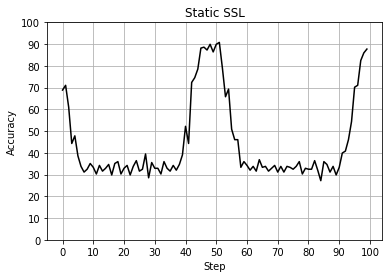

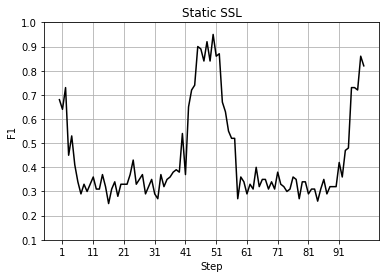




METHOD: Sliding lp as classifier
Execution time:  0.8185766642660093
Average micro-F1: 0.41019999999999995
Average Accuracy:  40.7057
Standard Deviation:  12.7494085553
Variance:  162.54741851


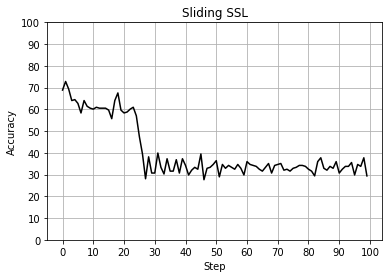

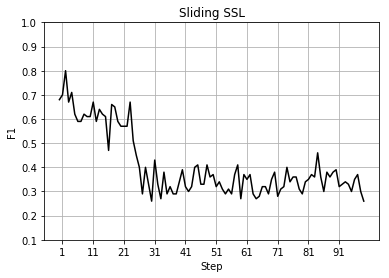




METHOD: Incremental lp as classifier
Execution time:  16.759324144464536
Average micro-F1: 0.44630000000000003
Average Accuracy:  45.0565
Standard Deviation:  18.6796798353
Variance:  348.93043875


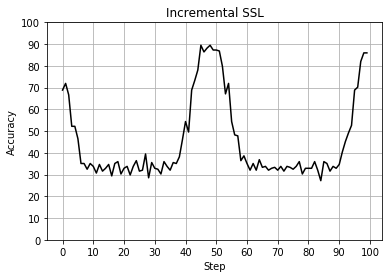

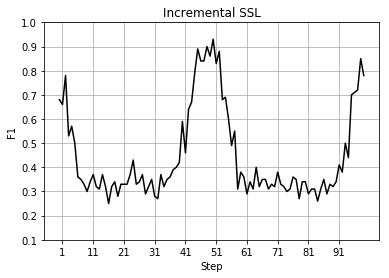




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  1.5053260225872478
Average micro-F1: 0.40409999999999996
Average Accuracy:  39.9954
Standard Deviation:  12.3434521444
Variance:  152.36081084


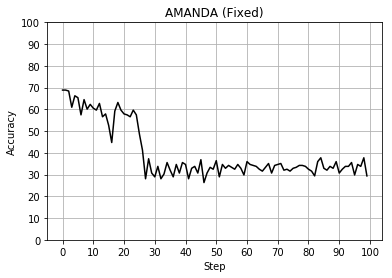

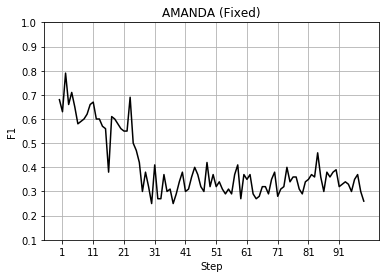




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  69.72055912274207
Average micro-F1: 0.24320000000000003
Average Accuracy:  24.4741
Standard Deviation:  11.0277353156
Variance:  121.61094619


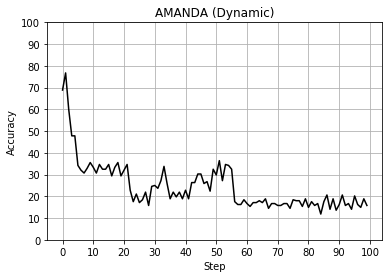

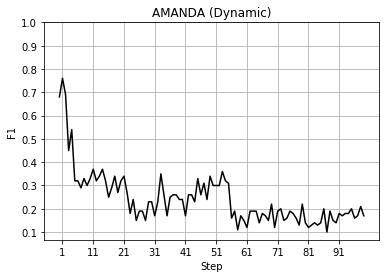




METHOD: None as classifier and GMM with BIC and Mahalanobis as core support extraction
gmmWithBIC: Error to choose the best GMM model
gmmWithBIC: Error to choose the best GMM model


AttributeError: 'NoneType' object has no attribute 'precisions_'

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_labelpropagation
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load5CVT(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_labelpropagation, 6, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 6, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 6, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 6, 0.65, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)

    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 6)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '5CVT', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()